In [1]:
import os
from pycode.draw import draw

Welcome to JupyROOT 6.22/00


In [2]:
import ROOT as R
import pandas as pd
import numpy as np
from root_numpy import root2array, tree2array
from root_numpy import array2hist, fill_hist
import itertools
from array import array

In [3]:
R.gStyle.SetOptStat(0)
R.gStyle.SetPadRightMargin(0.05)

In [4]:
{DIR_IN = '/Users/nbartosi/Cernbox/work/mu_collider/data/root/root'
FILES_IN = [os.path.join(DIR_IN, name) for name in ['pgun_mumi_100k.root', 'bib/bib.root']]}

In [5]:
DIR_IN = '~/cernbox/work/mu_collider/data/dl_filter/'
FILES_IN = [os.path.join(DIR_IN, name) for name in ['pgun_mumi_100k_mod4_OverlayBIB_fixedBIB_tuple.root']]

In [6]:
files_in = [R.TFile(file_in) for file_in in FILES_IN]
trees = [file_in.Get('MyLCTuple') for file_in in files_in]

### Constructing the SimHit DataFrame

In [7]:
def tree2dataframe(tree):
    """Converts a tree to a dataframe"""
    # Defining the columns to read from the TTree into an array
    # cols = ['stori', 'stpox', 'stpoy', 'stpoz', 'sqrt(stpox*stpox + stpoy*stpoy)', 'stci0', 'stci1', 'sttim - 1e6*sqrt(stpox*stpox + stpoy*stpoy + stpoz*stpoz)/TMath::C()', 'stedp*1e6', 'stmcp']
    # coln = ['stori', 'stpox', 'stpoy', 'stpoz', 'stpor', 'stci0', 'stci1', 'sttim', 'stedp', 'stmcp']
    cols = ['thori', 'thpox', 'thpoy', 'thpoz', 'TMath::ATan2(sqrt(thpox*thpox + thpoy*thpoy), thpoz)', 'TMath::ATan2(thpox, thpoy)', 'sqrt(thpox*thpox + thpoy*thpoy)', 'thci0', 'thtim', 'thedp*1e6']
    coln = ['thori', 'thpox', 'thpoy', 'thpoz', 'ththeta', 'thphi', 'thpor', 'thci0', 'thtim', 'thedp']

    treearr = tree2array(tree,
                branches=cols,
                start=0, stop=30000)
    # Constructing the DataFrames
    df = None
    dfs = []
    print('Converting events to dataframes')
    for event, arr in enumerate(treearr):
        type(arr)
        a = np.concatenate(arr).reshape([len(arr), len(arr[0])]).transpose()
        dfe = pd.DataFrame(a, columns=coln)
        dfe['event'] = event
        if event % 1000 == 0:
            print(event)
        dfs.append(dfe)
    print(' + Done')
    #     if df is None:
    #         df = dfe
    #     else:
    #         df = pd.concat([df, dfe], ignore_index=True)
    print('Merging {0:d} dataframes'.format(len(dfs)))
    df = pd.concat(dfs, ignore_index=True)
    print(' + Done')
    print('Formatting the dataframe')
    # # Correcting types
    # df['stmcp'] = df['stmcp'].astype(np.uint)
    # df['stori'] = df['stori'].astype(np.int)
    # df['stci0'] = df['stci0'].astype(np.uint32)
    # df['stci1'] = df['stci1'].astype(np.uint32)
    # # Adding side/layer information
    # df['stcis'] = (df['stci0'].values >> 5) & 0b11
    # df['stcil'] = (df['stci0'].values >> 7) & 0b111111
    # Correcting types
    df['thori'] = df['thori'].astype(np.int)
    df['thci0'] = df['thci0'].astype(np.uint32)
    # Adding side/layer information
    df['thcis'] = (df['thci0'].values >> 5) & 0b11
    df['thcil'] = (df['thci0'].values >> 7) & 0b111111
    print(' + Done')
    return df

In [8]:
dfs = [tree2dataframe(tree) for tree in trees]

Converting events to dataframes
0
 + Done
Merging 1 dataframes
 + Done
Formatting the dataframe
 + Done


### Booking histograms

In [9]:
NHISTOS = 4
histos = [{
    'nLayerHits': R.TH1F('nLayerHits{0:d}'.format(i), ';Layer ID;Hits', 8,0,8),
    'sublayerDRmin': R.TH1F('sublayerDRmin{0:d}'.format(i), ';#DeltaR_{min} [rad];Hits [a.u.]', 500,0,0.05),
    'sublayerDPhi_closest': R.TH1F('sublayerDPhi_closest{0:d}'.format(i), ';#Delta#phi_{closest} [rad];Hits [a.u.]', 500,0,0.05),
    'sublayerDZ_closest': R.TH1F('sublayerDZ_closest{0:d}'.format(i), ';#DeltaZ_{closest} [mm];Hits [a.u.]', 5000,0,5.0),
    'sublayerDTheta_closest': R.TH1F('sublayerDTheta_closest{0:d}'.format(i), ';#Delta#theta_{closest} [rad];Hits [a.u.]', 1000,0,0.01),
    'sublayerDR_closest': R.TH1F('sublayerDR_closest{0:d}'.format(i), ';#DeltaR_{closest} [mm];Hits [a.u.]', 3000,0,3.0),
    'posZ': [R.TH1F('posZ{0:d}_{1:d}'.format(i, j), ';Z [mm];Hits [a.u.]', 4000,-400,400) for j in range(8)],
    'posR': [R.TH1F('posR{0:d}_{1:d}'.format(i, j), ';R [mm];Hits [a.u.]', 3000,0,150) for j in range(8)],
} for i in range(NHISTOS)]
    

### Filling histograms

In [10]:
for i, df in enumerate(dfs):
    for iH, ori in enumerate([1,2,3,4]):
        h = histos[iH]['nLayerHits']
        h.Reset()
    #     nLayerHits = df[(df['thori'] == 1)].groupby('thcil')['thcil'].count()
    #     array2hist(nLayerHits, histos[i]['nLayerHits'])
        nLayerHits = df[(df['thori'] == ori)]['thcil']
        fill_hist(h, nLayerHits)

### Drawing histograms

Info in <TCanvas::Print>: pdf file /Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_04_21_tracker/digi/plots/nLayerHits_vtxe.pdf has been created


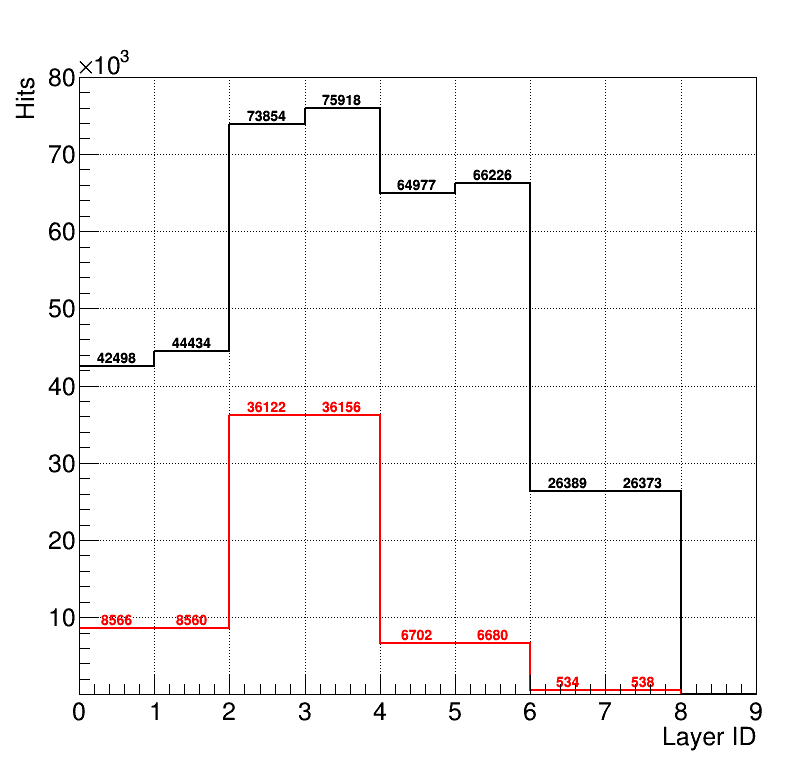

In [11]:
hists = [histos[i]['nLayerHits'] for i in [2,3]]
config = {'canvas': (800, 800),
          'color': [1, R.kRed, R.kAzure+2],
#           'leg': ['timing cut', '+ double layer cut'],
          'y': (10, 8e4),
          'x': (0, 10),
          'logY': False,
          'drawopt': 'hist text00'
         }
DIR_OUT = '~/pdc/muoncdata/users/bartosik/clic/studies/2020_04_21_tracker/digi/plots'
out = None
out = os.path.join(DIR_OUT, 'nLayerHits_vtxe.pdf')
draw(hists, config, out)

In [ ]:
h = [histos[i]['nLayerHits'] for i in range(3)]
config = {'canvas': (1000, 800),
          'color': [1, R.kAzure+2, R.kRed],
          'leg': ['IP #mu^{#pm}', 'BIB e^{#pm}', 'BIB #gamma'],
          'y': (0, 1e5),
          'x': (0, 10)
         }
DIR_OUT = '~/pdc/muoncdata/users/bartosik/clic/studies/2020_04_21_tracker/plots'
out = None
# out = os.path.join(DIR_OUT, 'nLayerHits_vtxe.pdf')
draw(h, config, out)

In [134]:
df_sel = (df['stori'] == 1) & (df['sttim'] < 0.15) & (df['sttim'] > -0.15) & (df['stcis'] == 0)
# df_g = df[df_sel].groupby(['stcis', 'stcil'])
df_g = df[df_sel].groupby(['event', 'stmcp'])

In [153]:
df_g['stcil'].nunique().sort_values()

event  stmcp
0      8939     1
1673   13490    1
       15195    1
       19321    1
       22563    1
               ..
490    12153    4
1765   9822     4
1664   2812     4
490    12173    4
1726   18645    4
Name: stcil, Length: 83089, dtype: int64

In [154]:
df.loc[df_g.groups[(1726, 18645)]]

,stori,stpox,stpoy,stpoz,stpor,stci0,stci1,sttim,stedp,stmcp,event,stcis,stcil
6473919,1,0.470382,30.165000,-13.908739,30.168667,32769,0,-0.029664,49.981933,18645,1726,0,0
6473920,1,1.201505,32.215000,-9.217187,32.237398,32897,0,-0.013431,38.292506,18645,1726,0,1
6473921,1,20.076492,47.274817,44.557410,51.361210,24833,0,0.069726,75.440708,18645,1726,0,2
6473922,1,26.786702,47.488990,58.994793,54.522763,16769,0,0.081635,43.210290,18645,1726,0,3


### Calculating minimum dR between hits in sublayers

In [18]:
DIR_OUT = '~/pdc/muoncdata/users/bartosik/clic/studies/2020_04_21_tracker/plots'
# config = {'color': [1, R.kAzure+2, R.kRed],
#           'leg': ['IP #mu^{-}', 'BIB'],
#           'y': (0, 1),
# #           'x': (0, 1),
#           'logY': False,
#           'norm': 1.0,
#           'rebin': 8
#          }
# configs = {
#     'sublayerDRmin':         {'x': (0,0.03),  'y': (0,0.8),    'rebin': 2},
#     'sublayerDPhi_closest':  {'x': (0,0.03),  'y': (0,0.8),    'rebin': 2},
#     'sublayerDZ_closest':    {'x': (0,3.00),  'y': (0,0.05), 'rebin': 20},
#     'sublayerDR_closest':    {'x': (1.5,2.5), 'y': (0,1),  'rebin': 20},
# }
file_out = R.TFile(os.path.join(DIR_OUT, 'sublayer_histos_vtxb_v2.root'), 'RECREATE')
for layer in range(4):
    print('LAYER {0:d}'.format(layer))
    for i, df_name in enumerate(['mu','bib']):
        df = dfs[i]
        sel = (df['thori'] == 1) & ((df['thcil']/2).astype(int) == layer)
        sel0 = sel & (df['thcil']%2 == 0)
        sel1 = sel & (df['thcil']%2 == 1)
        tp0 = df.loc[sel0, ['ththeta', 'thphi', 'thpoz', 'thpor']].values
        tp1 = df.loc[sel1, ['ththeta', 'thphi', 'thpoz', 'thpor']].values.transpose()
#         break
        
#         continue
        print(i, len(tp0))
        dR_min = np.ones(len(tp0), dtype=np.float32)*100
        dPhi_closest = np.ones(len(tp0), dtype=np.float32)*100
        dTheta_closest = np.ones(len(tp0), dtype=np.float32)*100
        dZ_closest = np.ones(len(tp0), dtype=np.float32)*100
        dR_closest = np.ones(len(tp0), dtype=np.float32)*100
        for iH, tp in enumerate(tp0):
            dPhi = tp1[1] - tp[1]
            dPhi[dPhi > np.pi] -= np.pi*2
            dPhi[dPhi < -np.pi] += np.pi*2
            dTheta = tp1[0] - tp[0]
            dR = np.sqrt(np.square(dPhi) + np.square(dTheta))
            idx_closest = np.argmin(dR)
            dR_min[iH] = dR[idx_closest]
            dPhi_closest[iH] = abs(dPhi[idx_closest])
            dTheta_closest[iH] = abs(dTheta[idx_closest])
            dZ_closest[iH] = abs(tp[2] - tp1[2][idx_closest])
            dR_closest[iH] = abs(tp[3] - tp1[3][idx_closest])
        for hname, values in {
            'sublayerDRmin': dR_min,
            'sublayerDPhi_closest': dPhi_closest,
            'sublayerDTheta_closest': dTheta_closest,
            'sublayerDZ_closest': dZ_closest,
            'sublayerDR_closest': dR_closest
        }.items():
            h = histos[i][hname]
            h.Reset()
            fill_hist(h, values)
            name = '{0:s}_{1:s}_{2:d}'.format(hname, df_name, layer)
            h.Write(name)
file_out.Close()
print('+ Done')
        
#     # Drawing the hisotgrams
#     for hname in ['sublayerDRmin', 'sublayerDPhi_closest', 'sublayerDZ_closest', 'sublayerDR_closest']:
#         print('Drawing: {0:s}'.format(hname))
#         h = [histos[i][hname] for i in range(3)]
#         out = os.path.join(DIR_OUT, '{0:s}_vtxe_l{1:d}.pdf'.format(hname, layer+1))
#         config.update(configs[hname])
#         draw(h, config, out)
#     print('+ Done')

LAYER 0
0 23938
1 114583
LAYER 1
0 18734
1 26449
LAYER 2
0 15228
1 19586
LAYER 3
0 11999
1 15672
+ Done


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


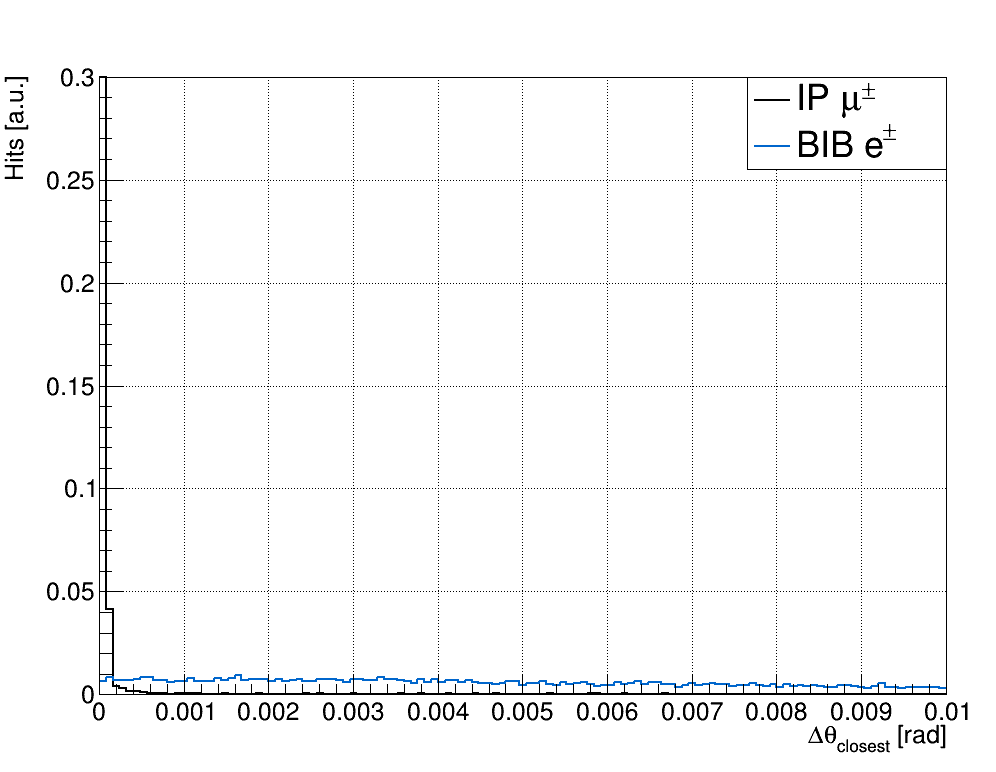

In [35]:
h = [histos[i]['sublayerDTheta_closest'] for i in range(2)]
config = {'color': [1, R.kAzure+2, R.kRed],
          'leg': ['IP #mu^{#pm}', 'BIB e^{#pm}', 'BIB #gamma'],
          'y': (0, 0.3),
          'x': (0, 0.01),
          'norm': 1.0,
          'rebin': 8
         }
DIR_OUT = '~/pdc/muoncdata/users/bartosik/clic/studies/2020_04_21_tracker/plots'
out = None
# out = os.path.join(DIR_OUT, 'sublayerDRmin_vtxb_l3.pdf')
draw(h, config, out)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


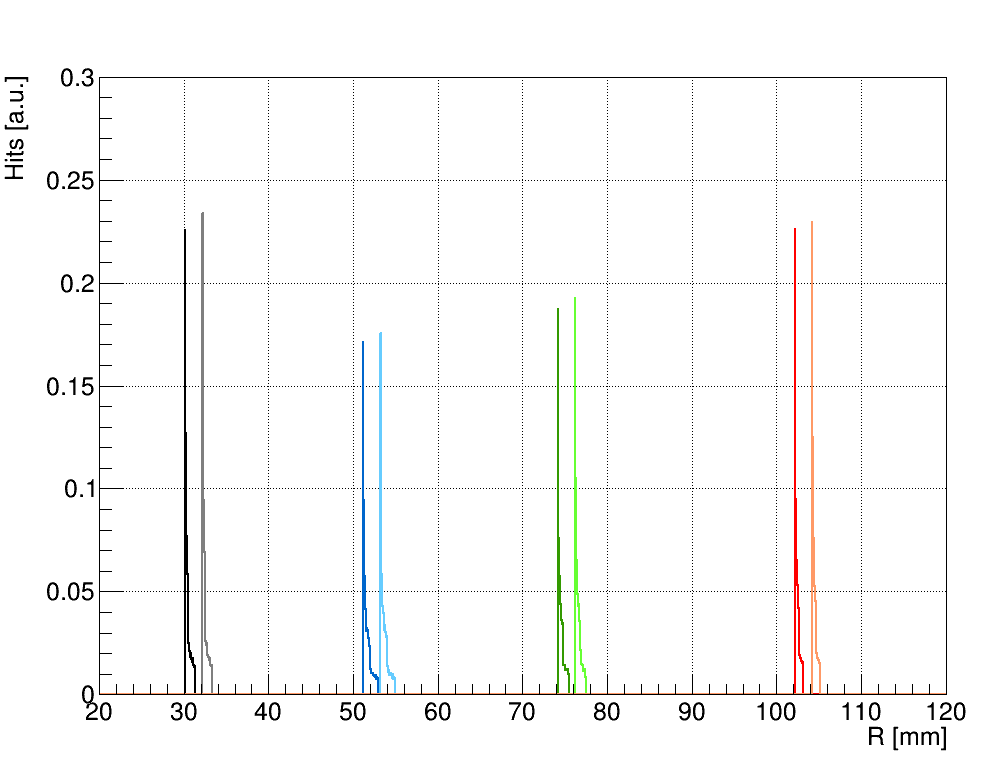

In [452]:
h = histos[0]['posR']
config = {'color': [1,14,  R.kAzure+2,R.kAzure+6,  R.kSpring-6,R.kSpring-2,  R.kRed,R.kOrange+6],
#           'leg': ['L{0:d}'.format(l) for l in range(8)],
          'y': (0, 0.3),
          'x': (20, 120),
          'norm': 1.0,
          'rebin': 1
         }
DIR_OUT = '~/pdc/muoncdata/users/bartosik/clic/studies/2020_04_21_tracker/plots'
out = None
# out = os.path.join(DIR_OUT, 'posZ_vtxb_IPmu.pdf')
draw(h, config, out)

In [239]:
layer = 3
df = dfs[1]
df[(df['thori'] == 1) & ((df['thcil']/2).astype(int) == layer)].groupby('event')['thcil'].nunique().mean()

1.3

In [114]:
area_barrel = [[65*2 * w * n]*2 for w, n in zip([13,23,24,24], [16,15,21,29])]
area_barrel = np.array(list(itertools.chain.from_iterable(area_barrel)), dtype=np.float32)
area_barrel = area_barrel / 1e2

In [115]:
print(', '.join(['{0:.2f}'.format(v) for v in (area_barrel)]))

270.40, 270.40, 448.50, 448.50, 655.20, 655.20, 904.80, 904.80


In [117]:
print(', '.join(['{0:.2f}'.format(v) for v in (nhits.values / area_barrel)]))

461.08, 383.91, 74.47, 63.20, 38.30, 34.92, 21.46, 19.48


In [69]:
df[(df['stori'] == 1) & (df['stcis'] == 0) & (df['sttim'].abs() < 0.3)].groupby(['event', 'stmcp'])['stcil'].count()

event  stmcp
0      8939      5
       8941      6
       9116      2
       12001     4
       12021     2
                ..
2992   21217     9
       21255    18
       21280    20
       21347    12
       21589    12
Name: stcil, Length: 117586, dtype: int64

In [100]:
np.array([756.88, 626.75, 116.5, 98.2, 63.5, 55.6, 41.8, 36.1]) / np.array([461.08, 383.91, 74.47, 63.20, 38.30, 34.92, 21.46, 19.48])

array([1.64153726, 1.63254409, 1.56438834, 1.55379747, 1.65796345,
       1.59221077, 1.94780988, 1.85318275])

In [108]:
nhits.sum()

375231

In [107]:
df[(df['stpor'] < 120) & (df['stpoz'].abs() < 70) & (df['sttim'].abs() < 0.15)]

,stori,stpox,stpoy,stpoz,stpor,stci0,stci1,sttim,stedp,stmcp,event,stcis,stcil
1,1,28.552599,-17.006291,34.366160,33.233490,114817,0,-0.147023,16.502387,21899,0,0,1
2,1,27.685557,-17.873333,32.661826,32.953696,114817,0,-0.132485,41.089083,21899,0,0,1
3,1,28.329954,-17.228936,29.075462,33.157541,114817,0,-0.089869,52.494157,21899,0,0,1
4,1,28.344582,-17.227883,29.109116,33.169493,114817,0,-0.089461,113.167669,21899,0,0,1
5,1,-99.460321,31.171165,20.281696,104.230500,107393,0,-0.133518,184.450837,21837,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11200280,1,18.382989,-49.980567,18.659931,53.254027,98689,0,0.099070,16.168402,21589,2992,0,3
11200281,1,19.607565,-49.582678,16.302100,53.318839,98689,0,0.113460,16.054686,21589,2992,0,3
11200282,1,18.306690,-50.005358,14.886359,53.251016,98689,0,0.124022,25.464626,21589,2992,0,3
11200283,1,19.524303,-49.609732,13.789396,53.313449,98689,0,0.138996,35.712874,21589,2992,0,3


In [157]:
tree.Print()

******************************************************************************
*Tree    :MyLCTuple : columnwise ntuple with LCIO data                       *
*Entries :   100000 : Total =       202208544 bytes  File  Size =  104152913 *
*        :          : Tree compression factor =   1.94                       *
******************************************************************************
*Br    0 :evevt     : evevt/I                                                *
*Entries :   100000 : Total  Size=     401024 bytes  File Size  =     140125 *
*Baskets :        7 : Basket Size=     115200 bytes  Compression=   2.86     *
*............................................................................*
*Br    1 :evrun     : evrun/I                                                *
*Entries :   100000 : Total  Size=     401024 bytes  File Size  =       2511 *
*Baskets :        7 : Basket Size=     115200 bytes  Compression= 159.51     *
*...................................................

In [188]:
dfs[2].shape

(1893698, 11)

In [28]:
histos[0]['nLayerHits'].Integral()

43873.0

,thori,thpoz,ththeta,thphi,thpor,thci0,thtim,thedp,event,thcis,thcil
0,1,-12.810598,1.968079,1.415809,30.530961,1,-0.065874,13.087772,0,0,0
1,1,-13.686300,1.968201,1.415606,32.606864,129,0.025762,14.222563,0,0,1
2,1,-21.753330,1.968284,1.412358,51.813979,257,0.011077,25.590401,0,0,2
3,1,-22.619673,1.968185,1.412060,53.892551,385,-0.040535,19.866040,0,0,3
4,1,-31.533478,1.968073,1.408417,75.153608,513,0.025961,14.307265,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
380142,1,46.072618,1.156921,2.323919,104.890163,205697,-0.066454,10.813507,29999,0,7
380143,3,56.889287,1.157556,2.308640,129.739500,285417475,-0.014627,81.989638,29999,0,0
380144,3,152.563473,1.151830,2.175296,342.582382,352886915,0.065595,44.581157,29999,0,1
380145,3,251.253467,1.146704,2.037239,556.498622,521036035,0.119200,26.863681,29999,0,2


In [72]:
d = dfs[0]
d['thl'] = R.TVector3(d['thpox'], d['thpoy'], d['thpoz'])

KeyError: 'thpox'

In [30]:
R.Math.VectorUtil.DeltaR

In [83]:
dfs[2].shape

(1893698, 13)

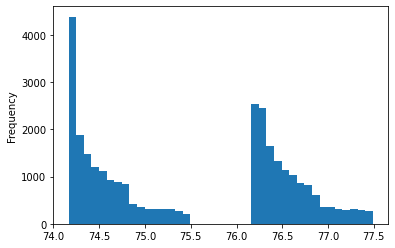

In [438]:
df = dfs[0]
sel = (df['thori'] == 1) & ((df['thcil']/2).astype(int) == 2)
sel0 = sel & (df['thcil']%2 == 0)
sel1 = sel & (df['thcil']%2 == 1)
df.loc[sel, 'thpor'].plot.hist(bins=40)

In [92]:
a1 = np.array([ 1.        ,  1.28539816,  3.57079633,  0.49778714,  6.28318531])

In [96]:
a1[np.argmin(a1)]

0.49778714

In [22]:
np.pi

3.141592653589793

In [12]:
import struct